# Object Description, part 2 - Advanced Object Descriptions

## Histogram of Oriented Gradients (HOG)
Divides an image into small cells, computes gradient magnitudes and orientations, and creates histograms of gradient directions for each cell.

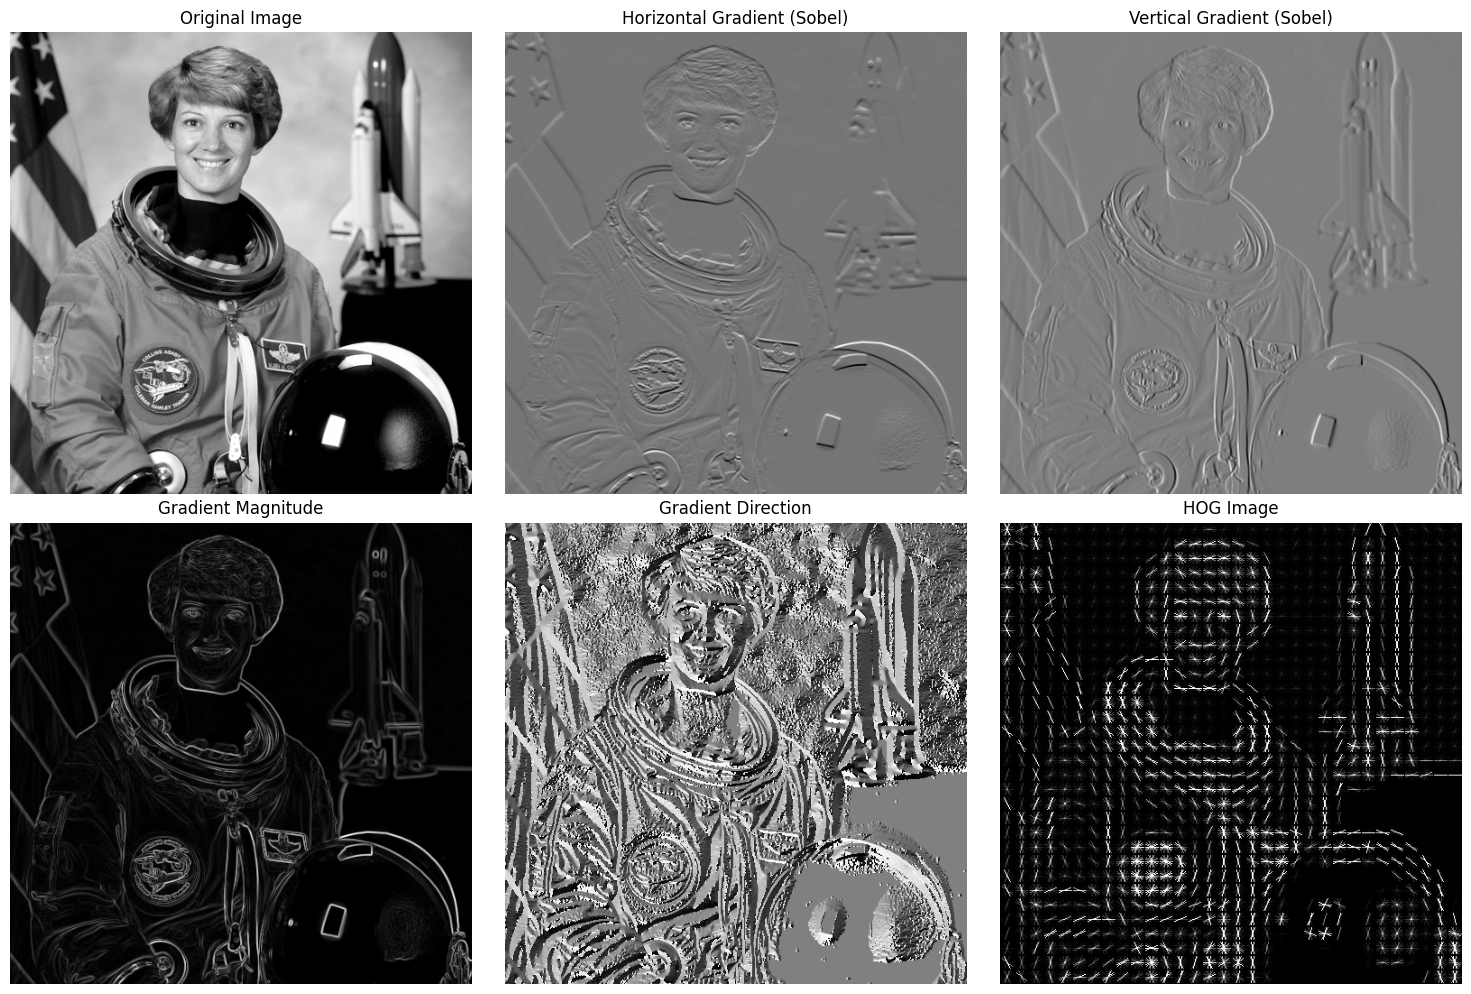

In [1]:
from PIL import Image
from skimage import data, feature, exposure, filters
import numpy as np
import matplotlib.pyplot as plt

# Load image and convert to grayscale
img = data.astronaut()
img_gray = np.array(Image.fromarray(data.astronaut()).convert('L'))

# Parameters for HOG
orientations = 9
pixels_per_cell = (16, 16)
cells_per_block = (1, 1)

# Compute HOG features for grayscale image
fd, hog_img = feature.hog(img_gray, orientations=orientations, pixels_per_cell=pixels_per_cell,
                                    cells_per_block=cells_per_block, visualize=True)

# Just for the visualization...
# - rescale the HOG images for better display
hog_img_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 10))

# - compute gradients using Sobel operator
gradient_x = filters.sobel_h(img_gray)  # horizontal gradients
gradient_y = filters.sobel_v(img_gray)  # vertical gradients

# - compute gradient magnitudes and directions
gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
gradient_direction = np.arctan2(gradient_y, gradient_x)

# Plotting
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Original grayscale image
ax[0, 0].imshow(img_gray, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 0].axis('off')

# Horizontal gradient
ax[0, 1].imshow(gradient_x, cmap='gray')
ax[0, 1].set_title('Horizontal Gradient (Sobel)')
ax[0, 1].axis('off')

# Vertical gradient
ax[0, 2].imshow(gradient_y, cmap='gray')
ax[0, 2].set_title('Vertical Gradient (Sobel)')
ax[0, 2].axis('off')

# Gradient Magnitude
ax[1, 0].imshow(gradient_magnitude, cmap='gray')
ax[1, 0].set_title('Gradient Magnitude')
ax[1, 0].axis('off')

# Gradient Direction (with color)
ax[1, 1].imshow(gradient_direction, cmap='gray')
ax[1, 1].set_title('Gradient Direction')
ax[1, 1].axis('off')

# HOG Image
ax[1, 2].imshow(hog_img_rescaled, cmap='gray')
ax[1, 2].set_title('HOG Image')
ax[1, 2].axis('off')

plt.tight_layout()
plt.show()

## Haar-like Features

Applies rectangular masks (e.g., edge, line, and diagonal features) over image regions to calculate weighted sums.

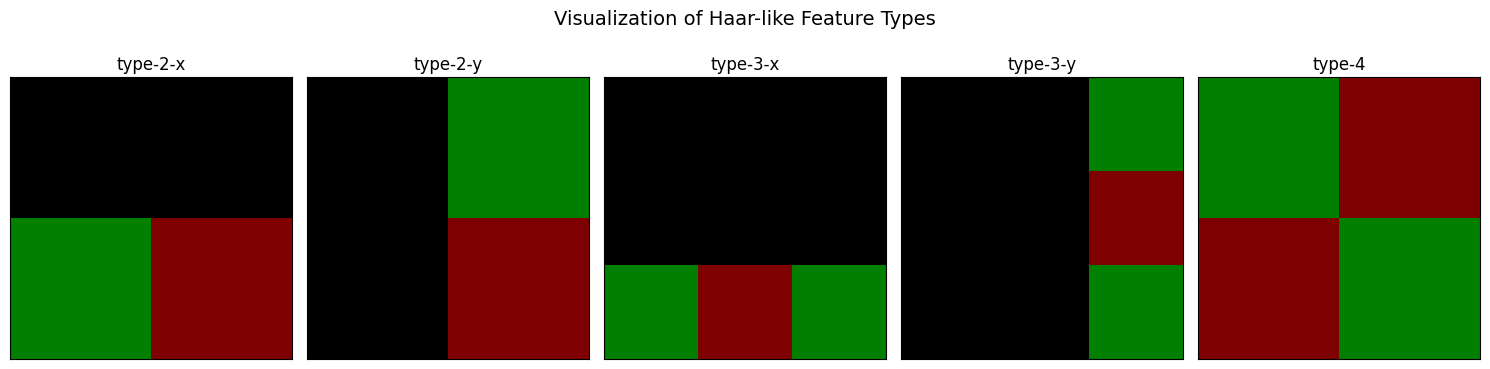

In [2]:
# Prepare empty images for visualization
features = [np.zeros((2, 2)), np.zeros((2, 2)), np.zeros((3, 3)), np.zeros((3, 3)), np.zeros((2, 2))]

# Define Haar-like feature types
feature_types = ['type-2-x', 'type-2-y', 'type-3-x', 'type-3-y', 'type-4']

# Plot Haar-like features
fig, axs = plt.subplots(1, 5, figsize=(15, 4))
for ax, feat, feat_t in zip(np.ravel(axs), features, feature_types):
    coord, _ = feature.haar_like_feature_coord(feat.shape[0], feat.shape[1], feat_t)
    haar_feature = feature.draw_haar_like_feature(feat, 0, 0, img.shape[0], img.shape[1], coord, max_n_features=1, rng=0)
    ax.imshow(haar_feature)
    ax.set_title(feat_t)
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle('Visualization of Haar-like Feature Types', fontsize=14)
plt.tight_layout()
plt.show()

**Note:**  
We now use the OpenCV library because it provides pre-trained classifiers optimized for real-time object detection, making it more efficient for Haar-like feature detection.

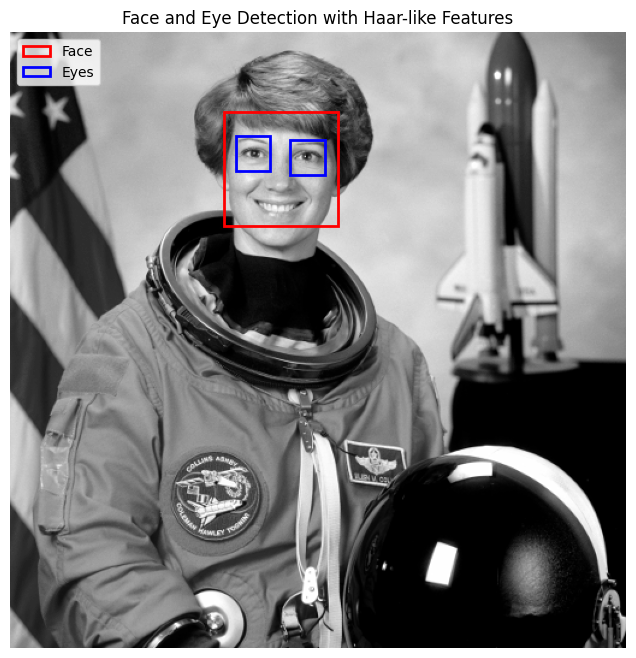

In [3]:
import cv2
import os
import urllib.request
import matplotlib.patches as patches

# Define the paths for the pre-trained Haar cascade classifiers
classifier_path_face = 'haarcascade_frontalface_default.xml'
classifier_path_eye = 'haarcascade_eye.xml'

# If the classifier files do not exist, download them
if not os.path.exists(classifier_path_face):
    url = 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml'
    urllib.request.urlretrieve(url, classifier_path_face)

if not os.path.exists(classifier_path_eye):
    url = 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml'
    urllib.request.urlretrieve(url, classifier_path_eye)

# Load the Haar Cascade classifiers
face_cascade = cv2.CascadeClassifier(classifier_path_face)
eye_cascade = cv2.CascadeClassifier(classifier_path_eye)

# Detect faces in the image
faces = face_cascade.detectMultiScale(img_gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Draw bounding boxes for faces and eyes using matplotlib
for (x, y, w, h) in faces:
    # Draw face rectangle (Red)
    rect_face = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none', label="Face")
    ax.add_patch(rect_face)
    
    # Region of interest (ROI) for eyes (inside the detected face)
    roi = img_gray[y:y + h, x:x + w]
    
    # Detect eyes within the face region
    eyes = eye_cascade.detectMultiScale(roi)
    for (ex, ey, ew, eh) in eyes:
        # Draw eye rectangle (Blue)
        rect_eye = patches.Rectangle((x + ex, y + ey), ew, eh, linewidth=2, edgecolor='blue', facecolor='none', label="Eyes")
        ax.add_patch(rect_eye)

# Add the legend for the bounding boxes
plt.title('Face and Eye Detection with Haar-like Features')
handles, labels = ax.get_legend_handles_labels()

# Remove duplicate labels
handles, labels = zip(*[(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]])
ax.legend(handles, labels, loc='upper left')

ax.imshow(img_gray, cmap='gray')
ax.axis('off')
plt.show()


## Local Binary Patterns (LBP)
Encodes an image region into a binary pattern by thresholding neighboring pixels relative to the center pixel.

![](https://ars.els-cdn.com/content/image/1-s2.0-S1568494619308014-gr9.jpg)

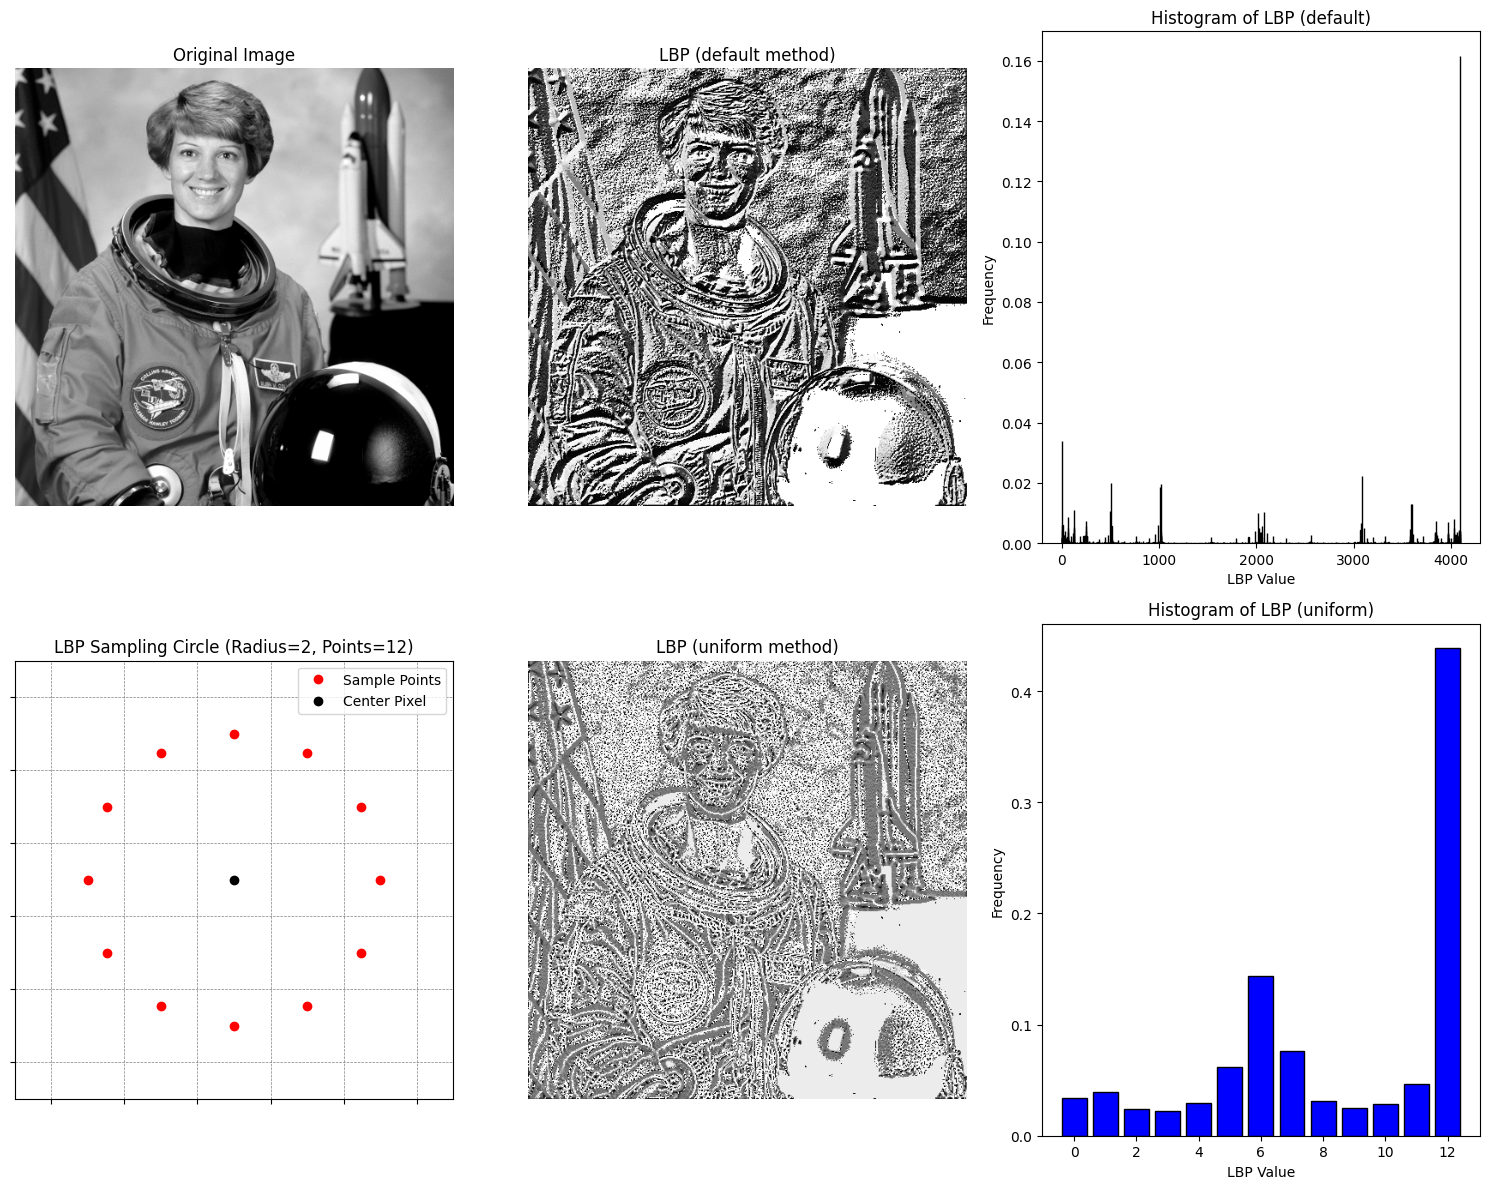

In [4]:
# Parameters for LBP
radius = 2
n_points = 12

# Compute LBP using 'default' and 'uniform' methods
# 'default': captures all possible binary patterns (no restriction on uniformity)
# 'uniform': encodes rotation-invariant patterns, reduces dimensionality of features
lbp_default = feature.local_binary_pattern(img_gray, n_points, radius, method='default')
lbp_uniform = feature.local_binary_pattern(img_gray, n_points, radius, method='uniform')

# Calculate histograms
bin_edges_default = np.arange(np.min(lbp_default), np.max(lbp_default) + 1)
bin_edges_uniform = np.arange(np.min(lbp_uniform), np.max(lbp_uniform) + 1)
lbp_hist_default, bin_edges_default = np.histogram(lbp_default.ravel(), bins=bin_edges_default, density=True)
lbp_hist_uniform, bin_edges_uniform = np.histogram(lbp_uniform.ravel(), bins=bin_edges_uniform, density=True)

# Create a sampling circle to visualize the neighborhood
angles = np.linspace(0, 2 * np.pi, n_points, endpoint=False)
circle_x = radius * np.cos(angles)
circle_y = radius * np.sin(angles)

# Plotting
fig, ax = plt.subplots(2, 3, figsize=(15, 12))

# Original image
ax[0, 0].imshow(img_gray, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 0].axis('off')

# LBP (default)
ax[0, 1].imshow(lbp_default, cmap='gray')
ax[0, 1].set_title('LBP (default method)')
ax[0, 1].axis('off')

# Histogram (default)
ax[0, 2].bar(bin_edges_default[:-1], lbp_hist_default, width=0.8, align='center', color='blue', edgecolor='black')
ax[0, 2].set_title('Histogram of LBP (default)')
ax[0, 2].set_xlabel('LBP Value')
ax[0, 2].set_ylabel('Frequency')

# Visualization of sampling circle
pixel_range = np.arange(-radius - 1, radius + 2, 1)
ax[1, 0].plot(circle_x, circle_y, 'ro', label='Sample Points')
ax[1, 0].scatter(0, 0, color='black', label='Center Pixel')
ax[1, 0].set_xticks(pixel_range + 0.5)
ax[1, 0].set_yticks(pixel_range + 0.5)
ax[1, 0].grid(color='gray', linestyle='--', linewidth=0.5)
ax[1, 0].set_xticklabels([])
ax[1, 0].set_yticklabels([])
ax[1, 0].set_xlim([-radius - 1, radius + 1])
ax[1, 0].set_ylim([-radius - 1, radius + 1])
ax[1, 0].set_aspect('equal')
ax[1, 0].set_title(f'LBP Sampling Circle (Radius={radius}, Points={n_points})')
ax[1, 0].legend()
ax[1, 0].axis('on')

# LBP (uniform)
ax[1, 1].imshow(lbp_uniform, cmap='gray')
ax[1, 1].set_title('LBP (uniform method)')
ax[1, 1].axis('off')

# Histogram (uniform)
ax[1, 2].bar(bin_edges_uniform[:-1], lbp_hist_uniform, width=0.8, align='center', color='blue', edgecolor='black')
ax[1, 2].set_title('Histogram of LBP (uniform)')
ax[1, 2].set_xlabel('LBP Value')
ax[1, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


**Note**:  
 In OpenCV, face detection can also be performed using **LBP (Local Binary Patterns) cascades**, which are generally **faster** but **less accurate than Haar cascades**. LBP is more suitable for real-time applications with limited computational resources.

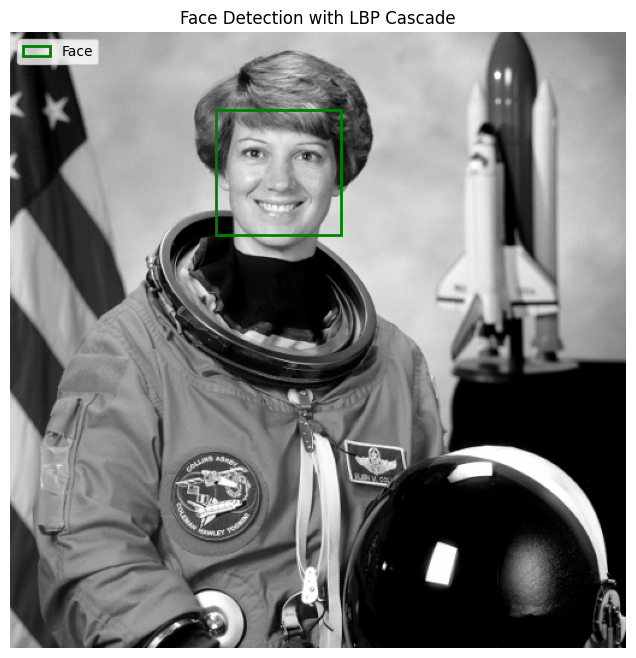

In [5]:
# Define the path for the pre-trained LBP cascade classifier
classifier_path_lbp = 'lbpcascade_frontalface.xml'

# If the classifier file doesn't exist, download it
if not os.path.exists(classifier_path_lbp):
    url = 'https://raw.githubusercontent.com/opencv/opencv/master/data/lbpcascades/lbpcascade_frontalface.xml'
    urllib.request.urlretrieve(url, classifier_path_lbp)

# Load the LBP Cascade classifier
lbp_face_cascade = cv2.CascadeClassifier(classifier_path_lbp)

# Detect faces in the image using LBP
faces_lbp = lbp_face_cascade.detectMultiScale(img_gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Draw bounding boxes for faces using matplotlib
fig, ax = plt.subplots(figsize=(10, 8))
for (x, y, w, h) in faces_lbp:
    rect_face = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='green', facecolor='none', label='Face')
    ax.add_patch(rect_face)

# Add title and legend
plt.title('Face Detection with LBP Cascade')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper left')

ax.imshow(img_gray, cmap='gray')
ax.axis('off')
plt.show()
